In [1]:
import tifffile as tf
import pandas as pd
import numpy as np
from skimage.transform import hough_circle, hough_circle_peaks
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from skimage.filters import gaussian
from skimage.draw import circle_perimeter
from skimage.morphology import dilation,disk

# Visualise an example


In [2]:
%matplotlib qt
fig, ax = plt.subplots(1,2)
names = ['NBD','LissRhod']
for i in range(images.shape[0]):
    ax[i].imshow(images[i],)
    ax[i].set_title(names[i])

NameError: name 'images' is not defined

# Threshold
## This is done as the GUV in the liss rhod channel is much brighter than the background

In [2]:
def create_bin_edges(image,n=3,alpha=1):
    bin_image = np.zeros_like(image)
    # threshold = threshold_otsu(images[1])
    threshold = np.median(image)+ n*np.std(image)
    bin_image[image> threshold ] = 1
    bin_image[image > threshold+alpha*np.std(image)]=0
    return bin_image

# Filter peaks for multiple detections
## This is achieved by setting an overlap threshold between pairs of peaks below which the two detections are considered to be from the same true peak.


### Firstly, we don't expect to find more than 8 guvs in one image for example. so we clip the detections to the top 8 detections

In [3]:
def clip_detections(accums,cx,cy,radii,N=8):
    accums = accums[:N]
    cx = cx[:N]
    cy = cy[:N]
    radii = radii[:N]
    return accums,cx,cy,radii


In [4]:
def dilate_detected_edges(img,r = 3):
    #dilates the thin edges found in membrane
    kernel = disk(r)
    return dilation(img,kernel)

In [5]:
def find_duplicates(cxcy):
    #cxcy -> ndarray of shape (N_detections,2): initial detected centre coordinates of circles
    
    for i in range(cxcy.shape[0]):
        peak = cxcy[i]
        rest  = cxcy[i+1:]

        dists = np.linalg.norm(rest - peak,axis = 1)
        if i == 0:

            multi_detections = np.nonzero(dists < 20)[0] +i+1
            
        else:
            multi_detections = np.concatenate((multi_detections,np.nonzero(dists < 20)[0]+i+1))

            
    return np.unique(multi_detections)

    

In [6]:
def remove_duplicates(accum,cx,cy,radii,duplicate_coords):
    #accum -> 1darray: ordered results of voting on hough circles
    #cx -> 1darray: most likely x coords by voting
    #cy -> 1darray: most likely y coords by voting
    #duplicate_coords -> 1darray: indices of duplicate detections to remove
    
    accum = np.delete(accum,duplicate_coords)
    cx = np.delete(cx,duplicate_coords)
    cy = np.delete(cy,duplicate_coords)
    radii = np.delete(radii,duplicate_coords)
    return accum,cx,cy,radii

In [7]:

def segment_detections(image,hough_vals):
    #image -> ndarray (512,512): raw image 
    #hough_vals -> tuple of 4 1d_arrays : post processed hough circle detection
    ##############  (accumulator,c_x,c_y,radii)
    
    
    detections_img  = np.zeros_like(image)
    i = 1
    for x,y, rad in zip(hough_vals[1],hough_vals[2],hough_vals[3]):

        circy,circx = circle_perimeter(y,x,rad)
        detections_img[circy[circx < 512][circy[circx <512] < 512],circx[circx < 512][circy[circx<512] < 512]] = i
        i +=1
    # plt.imshow(images[1])
    # plt.imshow(detections_img,alpha=1)

    return detections_img




# Create dictionary of guv membrane Intensities for both NBD and LissRhod

In [8]:
#configurations
radii = np.arange(20,35,2)
N = 100

In [9]:
radii25 = np.arange(15,35,2)

In [10]:


def getFretvals(image_directory,start_num,N_image,radii,N=100,n=2,CALIB2= False,alpha = 1):
    
    
    membrane_intensities={}
    guv_radii = {}
    

    for frame in range(start_num,N_image):
        frame = str(frame)
        if len(frame)==1:
            frame = '0'+str(frame)
        try:
            if CALIB2:
                tif = tf.TiffFile(image_directory+'/tifs/Image00'+frame+'CALIB2.tif')
            else:
                tif = tf.TiffFile(image_directory+'/tifs/Image00'+frame+'.tif')
        except FileNotFoundError:
            continue
        images = tif.asarray()
        #plt.imshow(images[1])

        detections_img = detect_guvs(images[1],radii,N,n,alpha)


        for _id in np.unique(detections_img):
        #  membrane_intensities[frame+'_'+str(_id)] = [np.mean(images[0][detections_img==_id]),np.mean(images[1][detections_img == _id])]

            print(images[0].shape)
            print((detections_img==_id).shape)
            print(images[0][detections_img==_id].shape[0])
            if images[0][detections_img==_id].shape[0] > 5000:
                print('here')
                continue

            guv_radii[frame+'_'+str(_id)] = len(detections_img[detections_img==_id])/(2*np.pi)
            membrane_intensities[frame+'_'+str(_id)]=np.array([images[0][detections_img==_id],images[1][detections_img == _id]])


        
    return membrane_intensities,guv_radii



In [11]:
def detect_guvs(image,radii,N,n,sigma = 2,alpha = 1):
    
    #Instantiate ax
    #ax = get_ax()
    
    #add_to_display(ax,image,'image')
    #smooth the image first
    smoothed_image = gaussian(image,sigma)
    #create binary edges for circle detection
    
    #add_to_display(ax,smoothed_image,'smoothed')
    
    bin_image = create_bin_edges(image,n,alpha)
    #plt.imshow(bin_i'multi_detections'mage)
    #circle detection with Hough transform
    #add_to_display(ax,bin_image,'binary')
    
    hough_res = hough_circle(bin_image,radii)

    hough_vals = hough_circle_peaks(hough_res,radii)

    #clip detections: we don't expect there to be more than a few GUVs in one frame

    hough_vals = clip_detections(*hough_vals,N)

    #reshape the peak coordinates to exploit some numpy optimizations

    cxcy = np.vstack((hough_vals[1],hough_vals[2])).T


    #Due to bug in scikit image hough circle peaks function, need to remove duplicates

    duplicates = find_duplicates(cxcy)

    hough_vals = remove_duplicates(*hough_vals,duplicates)

    #Segment instances of circles to get individual GUV membranes

    detections_img = segment_detections(image,hough_vals)
            
    detections_img = dilate_detected_edges(detections_img)
    #add_to_display(ax,detections_img,'Hough')
    #plt.show()
    
    return detections_img

In [12]:
def getAverageFRETValVid(vid_directory,vid_name,frame_no,radii,N=100,n=3,CALIB2= False):
        
    #Initialise dictionaries to store data
    
    membrane_intensities={}
    guv_radii = {}

    
    tif = tf.TiffFile(vid_directory+'/'+vid_name)
    
    #nbd and liss Rhod frames separate by half the frame length of video
    
    images = tif.asarray()
    
    
    detections_img = detect_guvs(images[1][frame_no],radii,N,n)
    
    
    for _id in np.unique(detections_img):
    #  membrane_intensities[frame+'_'+str(_id)] = [np.mean(images[0][detections_img==_id]),np.mean(images[1][detections_img == _id])]

        print(images[0][frame_no].shape)
        print((detections_img==_id).shape)
        print(images[0][frame_no][detections_img==_id].shape[0])
        if images[0][frame_no][detections_img==_id].shape[0] > 500:
            continue

        guv_radii[str(frame_no)+'_'+str(_id)] = len(detections_img[detections_img==_id])/(2*np.pi)/6
        membrane_intensities[str(frame_no)+'_'+str(_id)]=np.array([images[0][frame_no][detections_img==_id],images[1][frame_no][detections_img == _id]])


        
    return membrane_intensities,guv_radii


            

In [17]:
membrane_ib4,guv_radiib4 = getAverageFRETValVid('..','20200922_PCPGGUV_PEDOTAP31SUV_20xdilution.tif',22,radii)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mjsf3/20200922_PCPGGUV_PEDOTAP31SUV_20xdilution.tif'

In [106]:
membrane_ib4


{'22_1': array([[4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095,
         4095, 4095, 4095, 4095, 4095, 4095, 4095, 4095],
        [1495, 2072, 1568, 1279, 1

In [104]:
membrane_iafter,guv_radiiafter = getAverageFRETValVid('..','20200922_PCPGGUV_PEDOTAP31SUV_20xdilution.tif',54,radii)

(512, 512)
(512, 512)
219532
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
868
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
934
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
981
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
900
(512, 512)
(512, 512)
873
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1054
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
754
(512, 512)
(512, 512)
891
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
986
(512, 512)
(512, 512)
1029
(512, 512)
(512, 512)
746
(512, 512)
(512, 512)
1324
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
785
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1025
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1033
(512, 512)
(512, 512)
1056
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1073
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1083
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
763
(512, 512)
(512, 512)
876
(512, 512)
(512, 

# Get average membrane intensity per GUV


In [122]:
frets_b4 = {}
frets_after = {}

for key in membrane_ib4.keys():
    frets_b4[key] = np.array([np.median(membrane_ib4[key][1])/np.median(membrane_ib4[key][0])])
    
    
                                 
for key in membrane_iafter.keys():
    frets_after[key] = np.array([np.median(membrane_iafter[key][1])/np.median(membrane_iafter[key][0])])
    
                                   

In [123]:
fretsb4data = np.array(list(frets_b4.values()))
fretsb4keys = np.array(list(frets_b4.keys()))
radiib4data = np.array(list(guv_radiib4.values()))

In [124]:
fretsafterdata = np.array(list(frets_after.values()))
fretsafterkeys = np.array(list(frets_after.keys()))
radiiafterdata = np.array(list(guv_radiiafter.values()))

In [125]:
print(np.mean(fretsafterdata))
print(np.mean(fretsb4data))

1.8443431127406231
0.18588840686317673


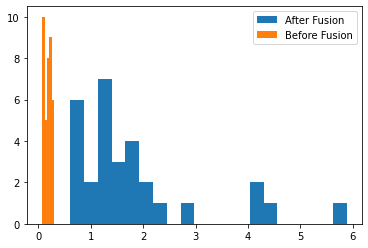

In [128]:
fig,ax = plt.subplots(1,1)
ax.hist(fretsafterdata,20)
ax.hist(fretsb4data,5)
ax.legend(['After Fusion','Before Fusion'])

# SUV PE:DOTAP fusion experiment

In [18]:
membrane_intensities10dot75,guv_radii10dot75 = getFretvals('./tifs1pc075pc/',1,11,radii)

(512, 512)
(512, 512)
260072
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
257448
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
136
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512,

In [47]:
membrane_intensities11,guv_radii11 = getFretvals('/home/marcus/20200827_NBDFRET_CALIB_1pcNBD1pcLissRhod/',10,28,radii,8,3)

In [13]:
membrane_i25,guv_radii25 = getFretvals('./tifs1pc025pcCALIB2/',1,21,radii25,alpha=2)

(512, 512)
(512, 512)
257259
here
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
864
(512, 512)
(512, 512)
769
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
696
(512, 512)
(512, 512)
696
(512, 512)
(512, 512)
259344
here
(512, 512)
(512, 512)
696
(512, 512)
(512, 512)
864
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
258583
here
(512, 512)
(512, 512)
788
(512, 512)
(512, 512)
692
(512, 512)
(512, 512)
864
(512, 512)
(512, 512)
597
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
253064
here
(512, 512)
(512, 512)
788
(512, 512)
(512, 512)
956
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
864
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
1028
(512, 512)
(512, 512)
696
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
1028
(512, 512)
(512, 512)
255304
here
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)
696
(512, 512)
(512, 512)
620
(512, 512)
(512, 512)


In [14]:
membrane_i01,guv_radii01 = getFretvals('./tifs01pc/',1,15,radii)

(512, 512)
(512, 512)
221329
here
(512, 512)
(512, 512)
1148
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
750
(512, 512)
(512, 512)
980
(512, 512)
(512, 512)
881
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1034
(512, 512)
(512, 512)
1208
(512, 512)
(512, 512)
1229
(512, 512)
(512, 512)
838
(512, 512)
(512, 512)
993
(512, 512)
(512, 512)
1104
(512, 512)
(512, 512)
1306
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
1324
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
976
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1416
(512, 512)
(512, 512)
1180
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1076
(512, 512)
(512, 512)
1348
(512, 512)
(512, 512)
1324
(512, 512)
(512, 512)
215
(512, 512)
(512, 512)
1324
(512, 512)
(512, 512)
1409
(512, 512)
(512, 512)
1031
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
1324
(512, 512)
(512, 512)
685
(512, 512)
(512, 512)
1416
(512, 512)
(512, 512)
1416
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1248
(512,

(512, 512)
(512, 512)
212001
here
(512, 512)
(512, 512)
1171
(512, 512)
(512, 512)
889
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
934
(512, 512)
(512, 512)
1165
(512, 512)
(512, 512)
871
(512, 512)
(512, 512)
1142
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
1324
(512, 512)
(512, 512)
1080
(512, 512)
(512, 512)
1182
(512, 512)
(512, 512)
1075
(512, 512)
(512, 512)
844
(512, 512)
(512, 512)
932
(512, 512)
(512, 512)
1138
(512, 512)
(512, 512)
1126
(512, 512)
(512, 512)
796
(512, 512)
(512, 512)
1073
(512, 512)
(512, 512)
1087
(512, 512)
(512, 512)
1139
(512, 512)
(512, 512)
1067
(512, 512)
(512, 512)
1324
(512, 512)
(512, 512)
1125
(512, 512)
(512, 512)
971
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1283
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1114
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1073
(512, 512)
(512, 512)
1068
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
736
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1125
(51

In [15]:
membrane_i04,guv_radii04 = getFretvals('./tifs04pc/',1,15,radii)

(512, 512)
(512, 512)
241332
here
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1042
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1107
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
1324
(512, 512)
(512, 512)
707
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
1061
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
903
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
234950
here
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1075
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1150
(512, 512)
(512, 512)
883
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1248
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
1013
(512, 512)
(512, 512)
10

(512, 512)
(512, 512)
225594
here
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1068
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1141
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
952
(512, 512)
(512, 512)
1059
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1150
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1023
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
945
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
917
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1119
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1101
(512, 512)
(512, 512)
1147
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
233083
here
(512, 512)
(512, 512)

# PE:DOTAP 3:1 suv fusion


In [20]:
#configurations
radii = np.arange(15,30,5)
N = 8

(512, 512)
(512, 512)
261248
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
261207
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
97
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
261164
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
261141
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
107
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
261168
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
140


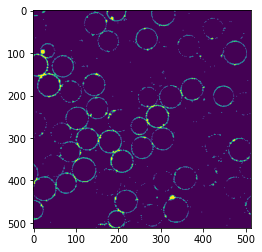

In [49]:
membrane_i20x,guv_radii20x = getFretvals('../20200921_PCPG31PEDOTAP31_20xsuvdilutionFRET/',58,74,radii,CALIB2=True)

(512, 512)
(512, 512)
261852
(512, 512)
(512, 512)
135
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
45
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
261758
(512, 512)
(512, 512)
134
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
261920
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
261164
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
262088
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
261810
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
138
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
261892
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
261948
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
140


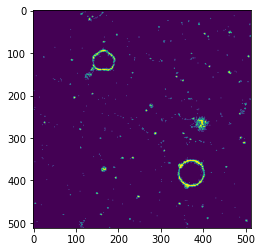

In [50]:
'multi_detections'membrane_i50x,guv_radii50x = getFretvals('../20200921_PCPG31PEDOTAP31_50x/',75,98,radii,CALIB2=False)

In [53]:
membrane_i50x

{'75_1': array([[3142, 3194, 1713, 1044, 1730, 1773, 1107,  634, 1547, 2833, 3717,
          772,  839, 1028,  933, 1332, 1553,  945, 1933,  934, 2702, 2748,
         1200,  595, 1963, 2228, 2008, 1376, 1108, 1954, 2571, 1078,  995,
         2498, 1881, 2940, 2082, 2402, 1523, 1507, 3087, 3037, 3226, 3110,
         1816, 2412, 3172, 3796, 2750, 4095, 1886, 4095, 1706, 4095, 3873,
         4095, 2400, 4095, 3191, 2268, 1828, 4095, 1251, 3757, 1683, 1738,
         2271, 3922,  957, 2915,  655, 1742, 2156, 3870, 1704, 4095, 3823,
          380, 1666, 2267, 1481, 2711,  656, 2710,  473, 1739, 3212, 2106,
         3007, 1566, 2545, 2367, 3969, 2351, 1918, 2649, 2096, 1037, 3843,
         1395, 3051, 2557, 1695, 1930, 1685, 2515, 1597, 2363, 1030, 2494,
         2944, 1885, 2430, 1423, 4095, 4095, 1189, 2055, 4095, 4095, 4041,
         2895,  448, 1751, 1843, 2675, 4095, 2519, 1714, 3887, 1849, 2656,
         1775, 1646, 1969],
        [1549, 2112, 1630, 1661, 1596, 1681, 1061, 1868, 3026, 2

(512, 512)
(512, 512)
262088
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
261642
(512, 512)
(512, 512)
138
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
261668
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
261668
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
261668
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
56
(512, 512)
(512, 512)
140
(512, 512)
(512, 512)
261640
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
84
(512, 512)
(512, 512)
112
(512, 512)
(512, 512)
112


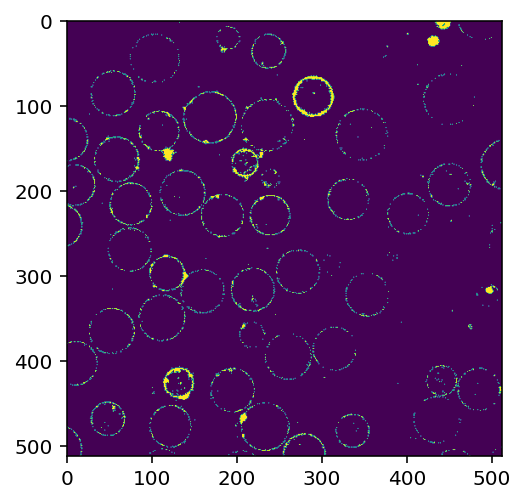

In [27]:
membrane_i200x,guv_radii200x = getFretvals('../20200921_PEDOTAP31PCPG31_200xsuvdilution/',34,45,radii,CALIB2=True)

# Visualising detection


In [38]:
%matplotlib inline
from ipywidgets import interactive,fixed
import matplotlib.pyplot as plt
import numpy as np

In [13]:


#first get the number of frames from user

start_num = 0
end_num = 102

#get experiment configs
vid_directory = '..'
vid_name = '20200922_PCPGGUV_PEDOTAP31SUV_20xdilution.tif'
n = 2
N = 100
#create ranges for slide bar

frame_rng = (start_num,end_num,1)

#Load video just once
tif = tf.TiffFile(vid_directory+'/'+vid_name)
frames = tif.asarray()

#define plotting function
def show_vidframe_detections(frame_no,frames,radii,N=100,n = 3):
    
    frame = frames[1][frame_no]
    detections_img = detect_guvs(frame,radii,N,n)
    #bin_image = create_bin_edges(frame,n)
    fig,axs = plt.subplots(1,2)
    axs[0].imshow(frame)
    axs[1].imshow(detections_img)

    
interactive_plot = interactive(show_vidframe_detections,frame_no=frame_rng,frames=fixed(frames),radii = fixed(radii),N = fixed(N),n=fixed(n))
output = interactive_plot.children[-1]
interactive_plot

FileNotFoundError: [Errno 2] No such file or directory: '/home/mjsf3/20200922_PCPGGUV_PEDOTAP31SUV_20xdilution.tif'

In [45]:
#first get the number of frames from user

start_num =1
end_num = 15

#get experiment configs
image_directory = './tifs04pc/'
n = 1
N = 100
#create ranges for slide bar

frame_rng = (start_num,end_num,1)

#define plotting function

def show_frame(frame,image_directory,n,N):
        
        frame = str(frame)
        if len(frame)==1:
            frame = '0'+str(frame)
        try:
            tif = tf.TiffFile(image_directory+'/tifs/Image00'+frame+'.tif')
        except FileNotFoundError:
            print('File path not correct')
            return
        images = tif.asarray()

            
        #create binary edges for circle detection
        bin_image = create_bin_edges(images[1],1)
        
        
        #circle detection with Hough transform
        hough_res = hough_circle(bin_image,radii25)

        hough_vals = hough_circle_peaks(hough_res,radii25)

        #clip detections: we don't expect there to be more than a few GUVs in one frame

        hough_vals = clip_detections(*hough_vals,N)

        #reshape the peak coordinates to exploit some numpy optimizations

        cxcy = np.vstack((hough_vals[1],hough_vals[2])).T
        
        
        #Due to bug in scikit image hough circle peaks function, need to remove duplicates

        duplicates = find_duplicates(cxcy)

        hough_vals = remove_duplicates(*hough_vals,duplicates)

        #Segment instances of circles to get individual GUV membranes

        detections_img = segment_detections(images[0],hough_vals)
        

        fig,axs = plt.subplots(1,2)
        axs[0].imshow(images[0])
        axs[1].imshow(detections_img)
        
        
interactive_plot = interactive(show_frame,frame=frame_rng,image_directory=fixed(image_directory),n=fixed(n),N = fixed(N))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=8, description='frame', max=15, min=1), Output()), _dom_classes=('widget…

In [16]:
%matplotlib qt
membrane_i50,guv_radii50 = getFretvals('./tifs1pc05pcCALIB2',1,11,radii,N=100,n=2)

(512, 512)
(512, 512)
227260
here
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
952
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
901
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
1039
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
992


In [17]:
%matplotlib qt
membrane_i0,guv_radii0 = getFretvals('../tifs1pcNBD0pcLissRhod/',7,14,radii,N=100,n=2)

(512, 512)
(512, 512)
231776
here
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1160
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
966
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
992
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
781
(512, 512)
(512, 512)
824
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
948
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
717
(512, 512)
(512, 512)
224946
here
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
1084
(512, 512)
(512, 512)
916
(512, 512)
(512, 512)
1096
(512, 512)
(

# Check that average NBD intensity decreases as Liss Rhod intensity increases

In [17]:
nbd_11 = np.array(list(membrane_intensities11.values()))[:,0]
liss_11 = np.array(list(membrane_intensities11.values()))[:,1]

In [18]:
nbd_75 = np.array(list(membrane_intensities10dot75.values()))[:,0]
liss_75 = np.array(list(membrane_intensities10dot75.values()))[:,1]


In [19]:
nbd_25 = np.array(list(membrane_i25.values()))[:,0]
liss_25 = np.array(list(membrane_i25.values()))[:,1]

In [20]:
nbd_50 = np.array(list(membrane_i50.values()))[:,0]
liss_50 = np.array(list(membrane_i50.values()))[:,1]

In [21]:
nbd = [np.median(nbd_11),np.median(nbd_75),np.median(nbd_50),np.median(nbd_25)]
liss = [np.median(liss_11),np.median(liss_75),np.median(liss_50),np.median(liss_25)]

In [23]:
%matplotlib qt
plt.scatter(nbd,liss)
plt.xlabel('Median NBD I [a.u.]')
plt.ylabel('Median Liss Rhod I [a.u.]')

Text(0, 0.5, 'Median Liss Rhod I [a.u.]')

In [46]:
nbd

[820.5803571428571, 1111.4375, 3100.2214285714285, 2117.901785714286]

In [47]:
liss

[901.3318993506493, 909.9928571428571, 3184.7061855670104, 654.3125]

In [54]:
radii11data

array([21.00845249, 26.10141067, 23.55493158, 21.00845249, 19.576058  ,
       23.55493158, 21.00845249, 12.73239545, 10.18591636, 23.07746675,
       15.27887454, 26.10141067, 26.10141067, 12.73239545, 21.00845249,
       10.18591636, 20.37183272, 10.18591636])

# Use numpy indexing to filter GUV detections by radius

In [34]:
frets1to0dot75 = {}
for key in membrane_intensities10dot75.keys():
    frets1to0dot75[key] = np.median(membrane_intensities10dot75[key][1])/np.median(membrane_intensities10dot75[key][0])

In [18]:
frets25 = {}
for key in membrane_i25.keys():
    frets25[key] = np.median(membrane_i25[key][1])/np.median(membrane_i25[key][0])

In [122]:
frets25

{'01_1': 1.3857404021937842,
 '01_2': 1.288548752834467,
 '01_3': 1.2623655913978495,
 '01_4': 1.2182336182336182,
 '01_5': 1.8060606060606061,
 '01_6': 1.2720207253886011,
 '01_7': 1.4402654867256637,
 '02_1': 1.2399127589967285,
 '02_2': 1.3739658025372312,
 '02_3': 1.3850031505986138,
 '02_4': 1.3155080213903743,
 '03_1': 1.3263046916183447,
 '03_2': 1.4579560155239328,
 '03_3': 1.2777264325323474,
 '03_4': 1.510144927536232,
 '03_5': 1.3839383938393839,
 '04_1': 1.266304347826087,
 '04_2': 1.7431106959364784,
 '04_3': 1.6230432060112712,
 '04_4': 1.2254016064257027,
 '04_5': 2.0931470392548235,
 '04_6': 1.5467289719626167,
 '04_7': 1.1525157232704402,
 '04_8': 1.4794520547945205,
 '04_9': 1.5310344827586206,
 '04_10': 1.7139107611548556,
 '04_11': 1.423044575273339,
 '04_12': 1.3761336515513127,
 '05_1': 1.7002176278563657,
 '05_2': 1.2792569659442725,
 '05_3': 1.9122426868905742,
 '05_4': 1.8008973639932697,
 '05_5': 1.1787234042553192,
 '05_6': 1.208012950222582,
 '05_7': 1.32881

In [19]:
frets11 = {}
for key in membrane_intensities11.keys():
    frets11[key] = np.median(membrane_intensities11[key][1])/np.median(membrane_intensities11[key][0])

NameError: name 'membrane_intensities11' is not defined

In [19]:
frets50 = {}
for key in membrane_i50.keys():
    frets50[key] = np.median(membrane_i50[key][1])/np.median(membrane_i50[key][0])

In [64]:
frets502 = {}
for key in membrane_i502.keys():
    frets502[key] = np.median(membrane_i502[key][1])/np.median(membrane_i502[key][0])

In [20]:
frets0 = {}
for key in membrane_i0.keys():
    frets0[key] = np.median(membrane_i0[key][1])/np.median(membrane_i0[key][0])

In [21]:
frets01 = {}
for key in membrane_i01.keys():
    frets01[key] = np.median(membrane_i01[key][1])/np.median(membrane_i01[key][0])

In [22]:
frets04 = {}
for key in membrane_i04.keys():
    frets04[key] = np.median(membrane_i04[key][1])/np.median(membrane_i04[key][0])

# SUV Fusion with suv dilution FRET


In [31]:
frets20x = {}
for key in membrane_i20x.keys():
    frets20x[key] = np.median(membrane_i20x[key][1])/np.median(membrane_i20x[key][0])

In [33]:
frets200x = {}
for key in membrane_i200x.keys():
    frets200x[key] = np.median(membrane_i200x[key][1])/np.median(membrane_i200x[key][0])

In [57]:
frets50x = {}
for key in membrane_i50x.keys():
    frets50x[key] = np.median(membrane_i50x[key][1])/np.median(membrane_i50x[key][0])

In [36]:
frets20xdata = np.array(list(frets20x.values()))
frets20xkeys = np.array(list(frets20x.keys()))
radii20xdata = np.array(list(guv_radii20x.values()))

In [37]:
frets200xdata = np.array(list(frets200x.values()))
frets200xkeys = np.array(list(frets200x.keys()))
radii200xdata = np.array(list(guv_radii200x.values()))

In [59]:
frets50xdata = np.array(list(frets50x.values()))
frets50xkeys = np.array(list(frets50x.keys()))
radii50xdata = np.array(list(guv_radii50x.values()))

In [58]:
frets50x

{'75_1': 0.8158396946564885,
 '75_2': 0.4629948364888124,
 '75_3': 0.2455968688845401,
 '75_4': 0.6767001114827201,
 '78_1': 0.8604880453537096,
 '78_2': 0.4499915952260884,
 '78_3': 0.4718768502072232,
 '78_4': 0.6704718417047184,
 '83_1': 0.6901455026455027,
 '83_2': 0.654320987654321,
 '87_1': 0.9825314128102973,
 '87_2': 0.9102413184226015,
 '87_3': 0.42967275015733164,
 '87_4': 0.47576843296247406,
 '87_5': 0.4024182561307902,
 '87_6': 0.7295654816165299,
 '87_7': 0.34391679211714793,
 '94_1': 0.8463980463980464,
 '95_1': 1.1074266922444505,
 '95_2': 1.1327077747989276,
 '95_3': 0.8568604191379993,
 '96_1': 0.4056166056166056,
 '96_2': 0.3924909529553679,
 '96_3': 0.5082056892778993,
 '97_1': 0.8143601190476191,
 '97_2': 0.4576777534355706}

In [39]:
frets20xdata = frets20xdata[radii20xdata < 30]
frets20xkeys = frets20xkeys[radii20xdata < 30]
radii20xdata = radii20xdata[radii20xdata < 30]

frets20xdata = frets20xdata[radii20xdata >= 10]
frets20xkeys = frets20xkeys[radii20xdata >= 10]
radii20xdata = radii20xdata[radii20xdata >= 10]

In [40]:
frets50xdata = frets50xdata[radii50xdata < 30]
frets50xkeys = frets50xkeys[radii50xdata < 30]
radii50xdata = radii50xdata[radii50xdata < 30]

frets50xdata = frets50xdata[radii50xdata >= 10]
frets50xkeys = frets50xkeys[radii50xdata >= 10]
radii50xdata = radii50xdata[radii50xdata >= 10]

In [41]:
frets200xdata = frets200xdata[radii200xdata < 30]
frets200xkeys = frets200xkeys[radii200xdata < 30]
radii200xdata = radii200xdata[radii200xdata < 30]

frets200xdata = frets200xdata[radii200xdata >= 10]
frets200xkeys = frets200xkeys[radii200xdata >= 10]
radii200xdata = radii200xdata[radii200xdata >= 10]

In [60]:
print(frets200xdata.shape)
print(frets20xdata.shape)
print(frets50xdata.shape)

(18,)
(34,)
(26,)


In [71]:
%matplotlib qt
#plt.hist(frets20xdata,10)
plt.hist(frets20xdata,35)
plt.hist(frets50xdata,10)
plt.hist(frets200xdata,10)


plt.legend(['20x','50x','200x'])
plt.xlabel('FRET ratio')

Text(0.5, 0, 'FRET ratio')

In [ ]:
fig,ax = plt.subplots(1,1)
ax.scatter([],[np.median(0),np.median(frets25data),np.median(frets502data),np.median(frets75data),np.median(frets11data)])
ax.errorbar([0,0.25,0.5,0.75,1],[np.median(0),np.median(frets25data),np.median(frets502data),np.median(frets75data),np.median(frets11data)],[np.std([0]),np.std(frets25data),np.std(frets50data),np.std(frets75data),np.std(frets11data)])
ax.set_xlabel('Liss Rhod membrane concentration %')
ax.set_ylabel('Fret Ratio')

# Calibration

In [65]:
frets11data = np.array(list(frets11.values()))
frets11keys = np.array(list(frets11.keys()))
radii11data = np.array(list(guv_radii11.values()))

In [66]:
frets75data = np.array(list(frets1to0dot75.values()))
frets75keys = np.array(list(frets1to0dot75.keys()))
radii75data=np.array(list(guv_radii10dot75.values()))

In [23]:
frets25data = np.array(list(frets25.values()))
frets25keys = np.array(list(frets25.keys()))
radii25data=np.array(list(guv_radii25.values()))

In [24]:
frets50data = np.array(list(frets50.values()))
frets50keys = np.array(list(frets50.keys()))
radii50data=np.array(list(guv_radii50.values()))

In [25]:
frets0data = np.array(list(frets0.values()))
frets0keys = np.array(list(frets0.keys()))
radii0data=np.array(list(guv_radii0.values()))

In [26]:
frets01data = np.array(list(frets01.values()))
frets01keys = np.array(list(frets01.keys()))
radii01data=np.array(list(guv_radii01.values()))

In [27]:
frets04data = np.array(list(frets04.values()))
frets04keys = np.array(list(frets04.keys()))
radii04data=np.array(list(guv_radii04.values()))

In [69]:
frets502data = np.array(list(frets502.values()))
frets502keys = np.array(list(frets502.keys()))
radii502data=np.array(list(guv_radii502.values()))

In [70]:
frets11data = frets11data[radii11data < 30]
frets11keys = frets11keys[radii11data < 30]
radii11data = radii11data[radii11data < 30]

frets11data = frets11data[radii11data >= 10]
frets11keys = frets11keys[radii11data >= 10]
radii11data = radii11data[radii11data >= 10]

In [71]:
frets75data = frets75data[radii75data < 30]
frets75keys = frets75keys[radii75data < 30]
radii75data = radii75data[radii75data < 30]

frets75data = frets75data[radii75data >= 10]
frets75keys = frets75keys[radii75data >= 10]
radii75data = radii75data[radii75data >= 10]

In [129]:
frets25data = frets25data[radii25data < 30]
frets25keys = frets25keys[radii25data < 30]
radii25data = radii25data[radii25data < 30]

frets25data = frets25data[radii25data >= 10]
frets25keys = frets25keys[radii25data >= 10]
radii25data = radii25data[radii25data >= 10]

In [130]:
frets50data = frets50data[radii50data < 30]
frets50keys = frets50keys[radii50data < 30]
radii50data = radii50data[radii50data < 30]

frets50data = frets50data[radii50data >= 10]
frets50keys = frets50keys[radii50data >= 10]
radii50data = radii50data[radii50data >= 10]

In [30]:
frets502data = frets502data[radii502data < 30]
frets502keys = frets502keys[radii502data < 30]
radii502data = radii502data[radii502data < 30]

frets502data = frets502data[radii502data >= 10]
frets502keys = frets502keys[radii502data >= 10]
radii502data = radii502data[radii502data >= 10]

NameError: name 'frets502data' is not defined

In [131]:
frets0data = frets0data[radii0data < 30]
frets0keys = frets0keys[radii0data < 30]
radii0data = radii0data[radii0data < 30]

frets0data = frets0data[radii0data >= 10]
frets0keys = frets0keys[radii0data >= 10]
radii0data = radii0data[radii0data >= 10]

In [133]:
frets50data

array([], dtype=float64)

In [28]:
%matplotlib qt
plt.hist(frets0data,10)
# plt.hist(frets11data,10)
# plt.hist(frets75data,10)
plt.hist(frets01data,10)
plt.hist(frets25data,10)
plt.hist(frets04data,10)
plt.hist(frets50data,10)
plt.legend(['0%','0.1%','0.25%',',0.4%','0.5%'])
plt.xlabel('FRET ratio')
plt.ylabel('# GUVs')

Text(0, 0.5, '# GUVs')

In [49]:
mem_means = {}
mem_means['NBD'] = {}
mem_means['Liss'] = {}

mem_means['NBD']['50'] =[]
mem_means['Liss']['50'] =[]

for key in membrane_i50.keys():
    mem_means['NBD']['50'].append(np.median(membrane_i50[key][0]))
    mem_means['Liss']['50'].append(np.median(membrane_i50[key][1]))

mem_means['NBD']['0'] =[]
mem_means['Liss']['0'] =[]

for key in membrane_i0.keys():
    mem_means['NBD']['0'].append(np.median(membrane_i0[key][0]))
    mem_means['Liss']['0'].append(np.median(membrane_i0[key][1]))
    
mem_means['NBD']['01'] =[]
mem_means['Liss']['01'] =[]

for key in membrane_i01.keys():
    mem_means['NBD']['01'].append(np.median(membrane_i01[key][0])) 
    mem_means['Liss']['01'].append(np.median(membrane_i01[key][1]))
mem_means['NBD']['04'] =[]
mem_means['Liss']['04'] =[]

for key in membrane_i04.keys():
    mem_means['NBD']['04'].append(np.median(membrane_i04[key][0]))
    mem_means['Liss']['04'].append(np.median(membrane_i04[key][1]))
    
mem_means['NBD']['25'] =[]
mem_means['Liss']['25'] =[]

for key in membrane_i25.keys():
    mem_means['NBD']['25'].append(np.median(membrane_i25[key][0]))
    mem_means['Liss']['25'].append(np.median(membrane_i25[key][1]))

In [30]:
list_radii_50 =[]
for key in membrane_i50.keys():
    list_radii_50.append(np.median(guv_radii50[key]))
list_radii_0 =[]
for key in membrane_i0.keys():
    list_radii_0.append(np.median(guv_radii0[key]))
list_radii_01 =[]
for key in membrane_i01.keys():
    list_radii_01.append(np.median(guv_radii01[key]))
list_radii_04 =[]
for key in membrane_i04.keys():
    list_radii_04.append(np.median(guv_radii04[key]))
list_radii_25 =[]
for key in membrane_i25.keys():
    list_radii_25.append(np.median(guv_radii25[key]))

In [33]:
plt.hist(list_radii_0,6,alpha = 0.3)
plt.hist(list_radii_01,6,alpha = 0.3)
plt.hist(list_radii_25,6,alpha = 0.3)
plt.hist(list_radii_04,6,alpha = 0.3)
plt.hist(list_radii_50,6,alpha = 0.3)
plt.legend(['0%','0.1%','0.25%','0.4%','0.5%'])
plt.title('Radii')

Text(0.5, 1.0, 'Radii')

Text(0.5, 1.0, 'LissRhod')

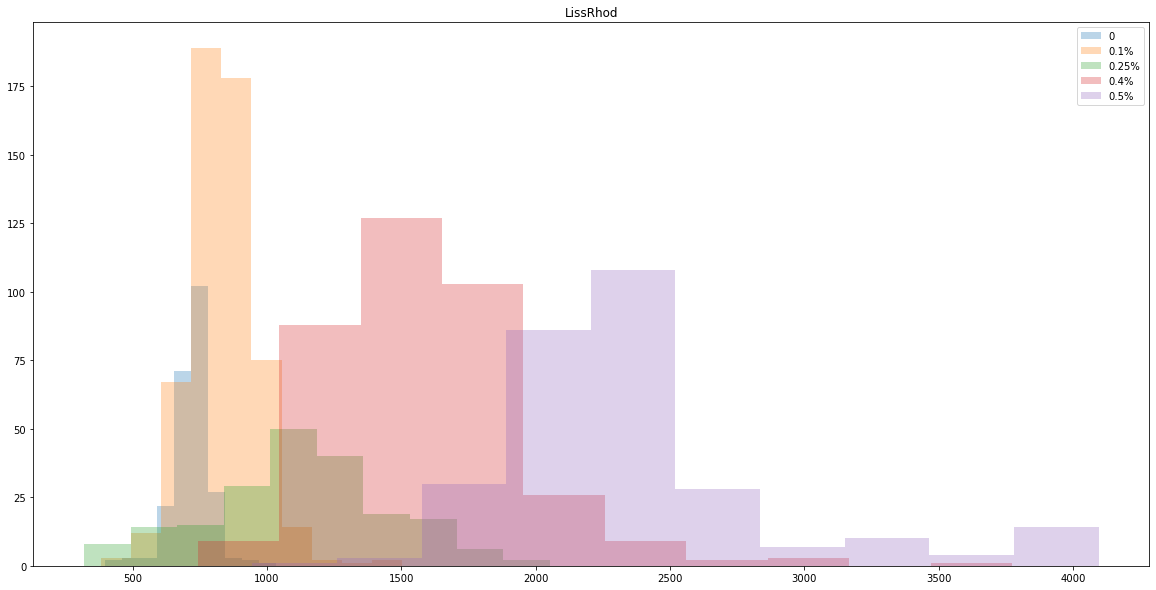

In [50]:
plt.figure()
plt.hist(mem_means['Liss']['0'],10,alpha = 0.3)
plt.hist(mem_means['Liss']['01'],10,alpha = 0.3)
plt.hist(mem_means['Liss']['25'],10,alpha = 0.3)
plt.hist(mem_means['Liss']['04'],10,alpha = 0.3)
plt.hist(mem_means['Liss']['50'],10,alpha = 0.3)
plt.legend(['0','0.1%','0.25%','0.4%','0.5%'])
plt.title('LissRhod')

In [79]:
%matplotlib qt

figSTD,axSTD = plt.subplots(1,1)

#produce plotting data of NBD and Liss Rhod channel signal variation
NBDstds = []
Lissstds = []

for key in mem_means['NBD']:
    stdsN = np.array(mem_means['NBD'][key])
    stdsL = np.array(mem_means['Liss'][key])
    NBDstds.append(np.std(stdsN))
    Lissstds.append(np.std(stdsL))
    
#x points
x = [0.5,0,0.1,0.4,0.25]

print(Lissstds)
print(NBDstds)


axSTD.scatter(x,NBDstds)
axSTD.scatter(x,Lissstds)
axSTD.set_xlabel('LissRhod membrane conc [%]')
axSTD.set_ylabel('Standard Deviation in membrane signal [a.u]')
axSTD.legend(['NBD','Liss Rhod'])


[536.4358415390581, 72.78594020183971, 124.71318287017986, 362.43183192150514, 338.9842202817116]
[231.62513331471854, 276.38689907888255, 188.32544312972394, 164.4755396789772, 229.92469146168276]


# Fit line to standard deviation vs membrane Liss Rhod

In [58]:
from scipy.optimize import curve_fit

In [62]:
paramsLiss = curve_fit(linear,x,Lissstds,p0=[500,50])
paramsNBD = curve_fit(linear,x,NBDstds,p0 = [0,200])

In [65]:
paramsLiss


(array([891.58983937,  64.17274352]),
 array([[15091.55751387, -3772.88934683],
        [-3772.88934683,  1456.33526936]]))

In [76]:
x_hat = np.arange(0,0.55,0.05)

NBD_hat = linear(x_hat,paramsNBD[0][0],paramsNBD[0][1])

In [77]:
Liss_hat = linear(x_hat,paramsLiss[0][0],paramsLiss[0][1])

In [80]:
axSTD.plot(x_hat,Liss_hat,color= 'tab:orange')
axSTD.plot(x_hat,NBD_hat,c= 'b')

In [47]:
%matplotlib qt
plt.hist(frets11data,10)
plt.hist(frets75data,10)
plt.legend(['1%','0.75%'])
plt.xlabel('FRET ratio')

Text(0.5, 0, 'FRET ratio')

In [36]:
plt.scatter(radii11data,frets11data)
plt.xlabel('Radius [pixels]')
plt.ylabel('FRET ratio')

Text(0, 0.5, 'FRET ratio')

In [23]:
plt.boxplot((frets75data,frets11data))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5bc5584490>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5bc55840a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5bc558f1c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5bc4fde250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5bc4fd3310>,
 'means': []}

In [51]:
fig,ax = plt.subplots(1,1)
ax.scatter([0,0.1,0.25,0.4,0.5],[np.mean(frets0data),np.mean(frets01data),np.mean(frets25data),np.mean(frets04data),np.mean(frets50data)])
ax.errorbar([0,0.1,0.25,0.4,0.5],[np.mean(frets0data),np.mean(frets01data),np.mean(frets25data),np.mean(frets04data),np.mean(frets50data)],[np.std(frets0data),np.std(frets01data),np.std(frets25data),np.std(frets04data),np.std(frets50data)])
ax.set_xlabel('Liss Rhod membrane concentration %')
ax.set_ylabel('Fret Ratio')
plt.title('Calibration 2')

Text(0.5, 1.0, 'Calibration 2')

In [56]:
from scipy.optimize import curve_fit


In [61]:
def linear(x,m,c):
    return m*x +c

In [41]:
params = curve_fit(linear,[0.,0.1,0.25,0.4,0.5],[np.mean(frets0data),np.mean(frets01data),np.mean(frets25data),np.mean(frets04data),np.mean(frets50data)],p0=4)

In [42]:
params

(array([6.73675454]), array([[0.0893936]]))

In [140]:
help(np.polyfit)

Help on function polyfit in module numpy:

polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
    Least squares polynomial fit.
    
    Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
    to points `(x, y)`. Returns a vector of coefficients `p` that minimises
    the squared error in the order `deg`, `deg-1`, ... `0`.
    
    The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
    method is recommended for new code as it is more stable numerically. See
    the documentation of the method for more information.
    
    Parameters
    ----------
    x : array_like, shape (M,)
        x-coordinates of the M sample points ``(x[i], y[i])``.
    y : array_like, shape (M,) or (M, K)
        y-coordinates of the sample points. Several data sets of sample
        points sharing the same x-coordinates can be fitted at once by
        passing in a 2D-array that contains one dataset per column.
    deg : int
        Degree of the fitting po

In [143]:
results = np.polyfit([0,0.25,0.5,0.75,1],[np.median(0),np.median(frets25data),np.median(frets502data),np.median(frets75data),np.median(frets11data)],1,cov = True)

In [144]:
results

(array([ 2.82567249, -0.26479731]),
 array([[ 0.2103958 , -0.1051979 ],
        [-0.1051979 ,  0.07889842]]))

In [146]:
from scipy.stats import linregress

In [148]:
help(linregress)

Help on function linregress in module scipy.stats._stats_mstats_common:

linregress(x, y=None)
    Calculate a linear least-squares regression for two sets of measurements.
    
    Parameters
    ----------
    x, y : array_like
        Two sets of measurements.  Both arrays should have the same length.  If
        only `x` is given (and ``y=None``), then it must be a two-dimensional
        array where one dimension has length 2.  The two sets of measurements
        are then found by splitting the array along the length-2 dimension.  In
        the case where ``y=None`` and `x` is a 2x2 array, ``linregress(x)`` is
        equivalent to ``linregress(x[0], x[1])``.
    
    Returns
    -------
    slope : float
        Slope of the regression line.
    intercept : float
        Intercept of the regression line.
    rvalue : float
        Correlation coefficient.
    pvalue : float
        Two-sided p-value for a hypothesis test whose null hypothesis is
        that the slope is zero, 

In [43]:
x = np.array([0,0.1,0.25,0.4,0.5])
x = x[:,np.newaxis]
y = np.array([np.median(frets0data),np.median(frets01data),np.median(frets25data),np.median(frets04data),np.median(frets50data)])
results = np.linalg.lstsq(x,y)

<ipython-input-43-9650fcd2a336>:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  results = np.linalg.lstsq(x,y)


In [44]:
results

(array([6.42253008]), array([0.14613249]), 1, array([0.6946222]))

In [45]:
ss_tot = np.sum((y-np.mean(y))**2)

In [46]:
rsquare = 1- results[1]/ss_tot

In [47]:
rsquare

array([0.97704733])